# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *B*

**Names:**

* *Mahammad Shirinov*
* *Keijiro Tajima*
* *Stephen Zhao*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

Scroll down past the next code block for exercise answer contents. This code block holds a significant portion of common helper functions used throughout the exercise notebook.

In [1]:
# Dependent Modules
import networkx as nx
import csv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

# Helper functions
def read_graph(filename) -> nx.Graph:
    G = nx.Graph()
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if (row[0][0] != '#'):
                G.add_edge(int(row[0]), int(row[1]))
    return G

def read_int_dict(filename) -> dict:
    res = {}
    with open(filename, 'r') as file:
        kvp_reader = csv.reader(file)
        for kvp in kvp_reader:
            assert(len(kvp) == 2)
            res[int(kvp[0])] = int(kvp[1])
    return res

def write_int_dict(d, filename):
    with open(filename, 'w') as file:
        for k, v in d.items():
            print('%d,%d' % (k, v), file=file)

def count_apsp_lengths(graph, apsp):
    # Initialize the counting
    counts = {}
    progress = 0
    next_progress_percent = 0
    total = graph.number_of_nodes()**2

    # Count them
    print('starting to count...')
    print('%d nodes in total, %d possible pairs.' % (graph.number_of_nodes(), total))

    for u, vs in apsp:
        for v, length in vs.items():
            # Increment appropriate count...
            if length not in counts:
                counts[length] = 1
            else:
                counts[length] += 1
            # Report progress...
            progress += 1
            if (progress * 100 // total) >= next_progress_percent:
                print('Counting at %d%%' % next_progress_percent)
                next_progress_percent += 5

    print('counting complete!')
    return counts

def complementary_cumulative(distro):
    comcum_degrees_counts = np.copy(distro)
    for i in range(1, len(comcum_degrees_counts)):
        comcum_degrees_counts[i] += comcum_degrees_counts[i-1]
    max_n = max(comcum_degrees_counts)
    return [max_n - n for n in comcum_degrees_counts]

## 2.1 Exploration of real networks

#### Exercise 2.1

##### Question 1

The following code loads the graph.

In [2]:
# Read the graph file
network1 = read_graph('../data/network1.csv')

##### Question 2

The following code checks for number of nodes and edges.

In [3]:
# Print graph stats
print('== Graph network1 ==')
print('number of nodes N: %d' % network1.number_of_nodes())
print('number of edges M: %d' % network1.number_of_edges())

== Graph network1 ==
number of nodes N: 13033
number of edges M: 18584


#### Exercise 2.2:  Node degree distribution

##### Question 1

For one, a histogram of the node degrees would help to naively visualize its distribution. A log scale is used on the y-axis because clustering & compactness force most nodes to only have very few neighbours, and very few nodes to have many neighbours.

This plot is created below.

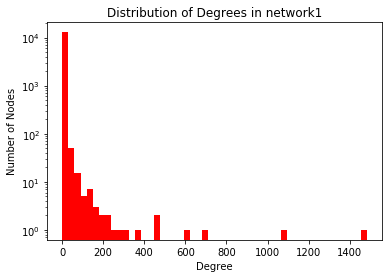

In [4]:
# Get degrees
network1_degrees = sorted([deg for (_, deg) in network1.degree])

# Plot a histogram
plt.hist(network1_degrees, bins=50, log=True, color='red')
plt.title('Distribution of Degrees in network1')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

Another way to view the distribution is on a log-log plot. The plot is created below.

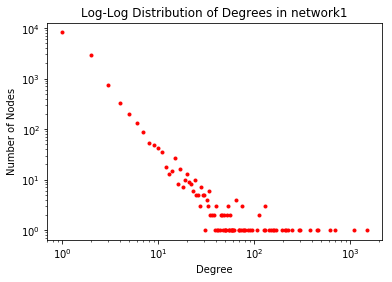

In [5]:
# Grab counts for each unique degree (histogram raw data)
network1_degree_uniques, network1_degree_counts = np.unique(network1_degrees, return_counts=True)

# Plot the distribution on a log-log graph
plt.loglog(network1_degree_uniques, network1_degree_counts, '.', c='red')
plt.title('Log-Log Distribution of Degrees in network1')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.xscale('log')
plt.yscale('log')
plt.show()

We also want to see the complementary cumulative distribution of degrees.

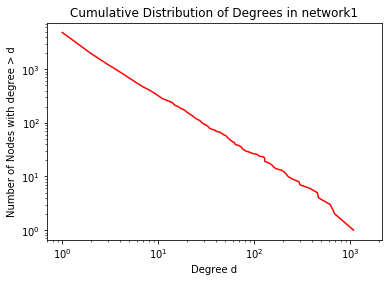

In [6]:
# Get node degree complementary cumulative data
network1_comcum_degrees = (network1_degree_uniques, complementary_cumulative(network1_degree_counts))

# Plot a the degree distributions
plt.loglog(network1_comcum_degrees[0], network1_comcum_degrees[1], color='red')
plt.title('Cumulative Distribution of Degrees in network1')
plt.xlabel('Degree d')
plt.ylabel('Number of Nodes with degree > d')
plt.show()

A linear pattern (in the log's) is now apparent. We will now draw the estimation line. To do so in a log-log projection, we invert the log-log mapping of the linear equation:

\begin{align}
                      & y = mx + b \\
\Leftrightarrow\space & \log_{10}{y'} = m\log_{10}{x'} + b && \text{using } y = \log_{10}{y'} \wedge x = \log_{10}{x'} \\
\Leftrightarrow\space & y' = ax'^m                         && \text{using } a = 10^b \\
\end{align}

And then we substitute the paramters $a$ and $m$. By eye, we estimate $b = 3.7$ and $m = -1.15$.

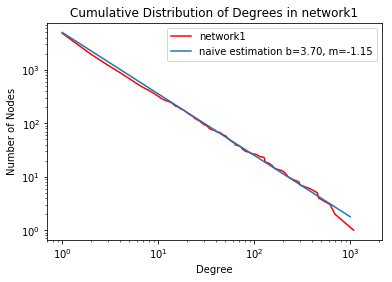

In [7]:
# Provide estimated y-intercept and slope of estimation line
network1_estimate_b = 3.7
network1_estimate_m = -1.15

# Compute the line
network1_estimate_x = np.linspace(1,1000,100)
network1_estimate_y = 10**network1_estimate_b * network1_estimate_x**network1_estimate_m

# Graph everything
plt.loglog(network1_comcum_degrees[0], network1_comcum_degrees[1], c='red')
plt.loglog(network1_estimate_x, network1_estimate_y)

plt.title('Cumulative Distribution of Degrees in network1')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.legend(['network1', 'naive estimation b=%.2f, m=%.2f' % (network1_estimate_b, network1_estimate_m)])

plt.show()

##### Question 2

Below there is some code to print out some stats of this distribution. If this network can be modeled by a $G(n,p)$ model, then $p = \frac{c}{n}$ and is also calculated below.

In [8]:
# Compute some stats 
network1_degree_mean = np.mean(network1_degrees)
network1_degree_sigma = np.std(network1_degrees)
network1_p = network1_degree_mean / network1.number_of_nodes()

# Print them
print('== Graph network1 degree distribution stats ==')
print("mean degree = %f" % network1_degree_mean)
print("standard deviation of degrees of network1 = %f" % network1_degree_sigma)
print('---')
print("min degree: %d" % np.min(network1_degrees))
print("median degree = %d" % np.median(network1_degrees))
print("max degree: %d" % np.max(network1_degrees))
print('---')
print("bernoulli trial probability p = %f" % network1_p)

== Graph network1 degree distribution stats ==
mean degree = 2.851838
standard deviation of degrees of network1 = 20.859854
---
min degree: 1
median degree = 1
max degree: 1482
---
bernoulli trial probability p = 0.000219


We also calculate the clustering coefficient and compare it to the bernoulli trial probability.

In [9]:
# Transitivity / Clustering
network1_closed_triples = 0
network1_connected_triples = 0
for u in network1.nodes:
    u_closed_triples = 0
    u_neighbors = network1.neighbors(u)
    for v in u_neighbors:
        for w in u_neighbors:
            if v != w and v in network1.neighbors(w):
                u_closed_triples += 1
    network1_closed_triples += u_closed_triples
    u_degree = network1.degree(u)
    network1_connected_triples += (u_degree * (u_degree - 1) /2) # u_degree choose 2
    
network1_clustering = network1_closed_triples / network1_connected_triples

print('network1 clustering coefficient (transitivity): %f' % network1_clustering)

network1 clustering coefficient (transitivity): 0.000831


##### Question 3

The distribution is close to a power law distribution, like the pareto distribution. It has two parameters, the scale $x_m$, and the shape (otherwise known as pareto index) $\alpha$.

The statisical approach to finding the parameters would be using maximum likelihood parameter estimation. The maximum likelihood estimation formulas are given below:

$$\text{(the scale):}\quad\hat{x}_m = \min_i{x_i}$$

$$\text{(the shape / pareto index):}\quad\hat{\alpha} = \frac{n}{\sum_i{\ln(x_i/\hat{x}_m)}}$$

Since the minimum degree observed is 1, we can try to assume that $\hat{x}_m = 1$, but we will soon notice that this estimate is not accurate. We will try other values of $\hat{x}_m$ as well. $\hat{\alpha}$ is also calculated below.

Here are the estimations we will use:
scale=1.0000, shape=2.4321
scale=0.8000, shape=1.5765
scale=0.7100, shape=1.3269


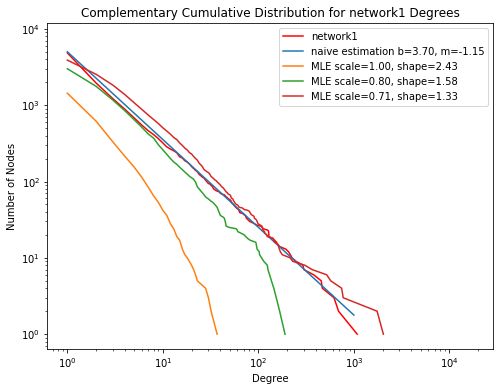

In [10]:
# List of scales we want to try
network1_pareto_mle_x_m = [1, 0.8, 0.71]

# Create dictionary of MLE estimations, indexed by estimated scale x_m
network1_pareto_mle_alpha = {}
for x_m in network1_pareto_mle_x_m:
    network1_pareto_mle_alpha[x_m] = network1.number_of_nodes() / np.sum(np.log(np.array(network1_degrees)/x_m))

print("Here are the estimations we will use:")
for x_m in network1_pareto_mle_x_m:
    print("scale=%.4f, shape=%.4f" % (x_m, network1_pareto_mle_alpha[x_m]))

# generate samples from estimated degree distributions
pareto_mle = {}
for x_m in network1_pareto_mle_x_m:
    pareto_mle[x_m] = np.random.pareto(network1_pareto_mle_alpha[x_m], network1.number_of_nodes()).round()

# Calculate the complementary cumulatives
pareto_mle_comcums = {}
for x_m in network1_pareto_mle_x_m:
    uniques, counts = np.unique(pareto_mle[x_m], return_counts=True)
    pareto_mle_comcums[x_m] = (uniques, complementary_cumulative(counts))

# Graph everything
fig = plt.figure(figsize=(8,6))
legend = []
plt.loglog(network1_comcum_degrees[0], network1_comcum_degrees[1], c='red')
legend.append('network1')
plt.loglog(network1_estimate_x, network1_estimate_y)
legend.append('naive estimation b=%.2f, m=%.2f' % (network1_estimate_b, network1_estimate_m))
for x_m in network1_pareto_mle_x_m:
    plt.loglog(pareto_mle_comcums[x_m][0], pareto_mle_comcums[x_m][1])
    legend.append('MLE scale=%.2f, shape=%.2f' % (x_m, network1_pareto_mle_alpha[x_m]))
plt.title('Complementary Cumulative Distribution for network1 Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.legend(legend)

plt.show()

Note that the pareto distribution's CCDF is the following:

$$CCDF(X > x; x_m, \alpha) = (\frac{x}{x_m})^{-\alpha}$$

Based on our graph, a good estimation for $x_m$ and $\alpha$ seem to be $0.7100$ and $1.3269$ respectively. This produces the following power function (normalized):

\begin{align}
    CCDF(X > x; x_m = \hat{x}_m, \alpha = \hat{\alpha})
                               &= CCDF(x; x_m = 0.71, \alpha = 1.3269) \\
                               &= (\frac{x}{0.71})^{-1.3269} \\
                               &\doteq 0.63 x^{-1.33}
\end{align}

If we scale this to our distribution of 13033 samples, we get $\hat{b} = \log(0.63 \times 13033) \approx 3.9$.

Let us attempt to verify our results based on the visual output and naive estimations for $m$ and $b$ in the linear equation from Question 1. We will correspond the result above with this formula from Question 1:

$$y' = 10^b x'^m$$

We found $m = -1.15$ and $b = 3.7$ by eye in Question 1, which is somewhat close to our $\hat{m} \approx -1.33$ and $\hat{b} \approx 3.9$ from the MLE.

#### Exercise 2.3: Giant component

##### Question 1

We will now compute the number of components.

In [11]:
# Compute it
network1_num_components = nx.number_connected_components(network1)

# Print it
print("Number of connected components in network1 = %d" % network1_num_components)

Number of connected components in network1 = 192


##### Question 2

We will take a look at the sizes of each component by getting the components, sorting them by size, and listing the top 10.

In [12]:
# Get the components
network1_components = sorted(nx.connected_components(network1), key=lambda C: len(C), reverse=True)
network1_component_sizes = [len(C) for C in network1_components]

# Print top 10 sizes
print("Top 10:    " + ", ".join(str(l) for l in network1_component_sizes[:10]))
print("Bottom 10: " + ", ".join(str(l) for l in network1_component_sizes[-10:]))

# Extract the giant component
network1_giant = network1.subgraph(network1_components[0])

Top 10:    12576, 16, 7, 6, 5, 5, 5, 4, 4, 4
Bottom 10: 2, 2, 2, 2, 2, 2, 2, 2, 2, 2


There appears to be a giant component with size 12576.

#### Exercise 2.4: Short paths & Small-worlds

Let us find out more about this graph.

We can start by computing the shortest path between any two nodes $u,v$ in the graph. This is the All-Pairs-Shortest-Path problem, solvable using Floyd-Warshall in $\theta(n^3)$ time.

**WARNING:** The code block below takes a really long time to run the first time!

In [13]:
from pathlib import Path

network1_apsp_counts_persist_file = 'network1_apsp_counts.txt'

network1_apsp_length_counts = {}

# Check for persisted APSP counts.
# If it exists, skip computation
if Path(network1_apsp_counts_persist_file).is_file():
    network1_apsp_length_counts = read_int_dict(network1_apsp_counts_persist_file)
    print('network1 path lengths read from file!')
    
else:
    # Get the APSP lengths
    network1_apsp_lengths = nx.all_pairs_shortest_path_length(network1)

    # Count them
    network1_apsp_length_counts = count_apsp_lengths(network1, network1_apsp_lengths)
    
    # Persist the results
    write_int_dict(network1_apsp_length_counts, network1_apsp_counts_persist_file)

network1 path lengths read from file!


In [14]:
# Compute some stats 
network1_apsp_unique_lengths = np.array(list(network1_apsp_length_counts.keys()))
network1_apsp_length_numberof = np.array(list(network1_apsp_length_counts.values()))
network1_apsp_total = sum(network1_apsp_length_numberof)
network1_apsp_length_mean = np.dot(network1_apsp_unique_lengths, network1_apsp_length_numberof)/network1_apsp_total

network1_apsp_length_mean_squared = network1_apsp_length_mean**2
network1_apsp_length_squared_mean = np.dot((network1_apsp_unique_lengths**2), network1_apsp_length_numberof)/network1_apsp_total

network1_apsp_length_variance = network1_apsp_length_squared_mean - network1_apsp_length_mean_squared
network1_apsp_length_sigma = np.sqrt(network1_apsp_length_variance)

# Print them
print('== Graph network1 path-length stats ==')
print("mean path-length = %f" % network1_apsp_length_mean)
print("standard deviation of path-lengths of network1 = %f" % network1_apsp_length_sigma)
print('---')
print("min path-length: %d" % np.min(network1_apsp_unique_lengths))
print("max path-length: %d" % np.max(network1_apsp_unique_lengths))

== Graph network1 path-length stats ==
mean path-length = 4.175128
standard deviation of path-lengths of network1 = 1.057287
---
min path-length: 0
max path-length: 12


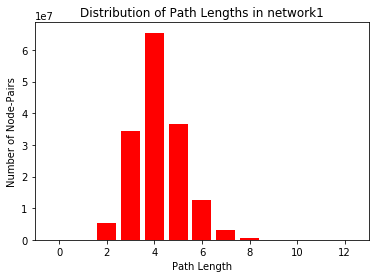

In [15]:
# Graph the distribution on a histogram
plt.bar(network1_apsp_length_counts.keys(), network1_apsp_length_counts.values(), color='red')
plt.title('Distribution of Path Lengths in network1')
plt.xlabel('Path Length')
plt.ylabel('Number of Node-Pairs')
plt.show()

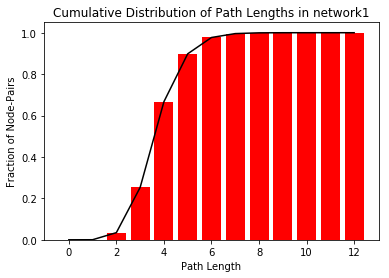

Percentage of nodes reached at path length 6: 97.69%


In [16]:
# Graph the distribution on a cumulative histogram
cumulative = np.array(list(network1_apsp_length_counts.values()))
for i in range(1, len(cumulative)):
    cumulative[i] += cumulative[i-1]
total = cumulative[-1]

plt.plot(network1_apsp_length_counts.keys(), cumulative/total, color='black')
plt.bar(network1_apsp_length_counts.keys(), cumulative/total, color='red')
plt.title('Cumulative Distribution of Path Lengths in network1')
plt.xlabel('Path Length')
plt.ylabel('Fraction of Node-Pairs')
plt.show()

print('Percentage of nodes reached at path length 6: %.2f%%' % (cumulative[6]/total*100))

Looking at the above graphs, we can visually conclude that both the median and mode path length is 4. Looking at the cumulative graph specifically, we can see that by path length of 6, we are quickly converging on all nodes. The exact statistic at length 6 is printed just below the graph.

Although it is not a perfect small-world by Duncan Watts's definition, we reach sufficiently enough nodes by path length 6 that it is essentially so. Therefore, we think network1 can be classified as a small-world.

#### Exercise 2.5: Network comparison

##### Question 1

We will now explore network2 below using the same tools we used for network1 above.

In [17]:
# Read the graph file
network2 = read_graph('../data/network2.csv')

== Graph network2 ==
number of nodes N: 26542
number of edges M: 43516


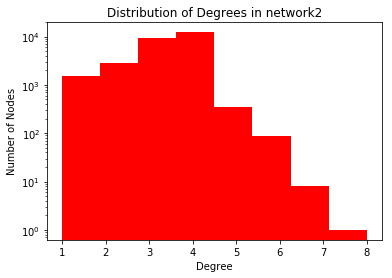

In [18]:
# Print graph stats
print('== Graph network2 ==')
print('number of nodes N: %d' % network2.number_of_nodes())
print('number of edges M: %d' % network2.number_of_edges())

# Get degrees
network2_degrees = sorted([deg for (_, deg) in network2.degree])

# Plot a histogram
plt.hist(network2_degrees, bins=8, log=True, color='red')
plt.title('Distribution of Degrees in network2')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

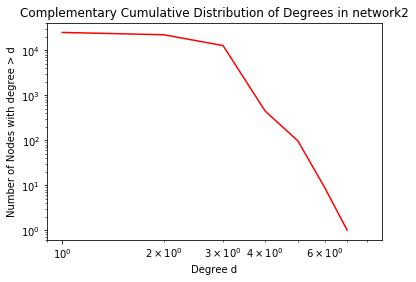

In [19]:
# Grab counts for each unique degree (histogram raw data)
network2_degree_uniques, network2_degree_counts = np.unique(network2_degrees, return_counts=True)

# Get node degree complementary cumulative data
network2_comcum_degrees = (network2_degree_uniques, complementary_cumulative(network2_degree_counts))

# Plot a the degree distributions
plt.loglog(network2_comcum_degrees[0], network2_comcum_degrees[1], color='red')
plt.title('Complementary Cumulative Distribution of Degrees in network2')
plt.xlabel('Degree d')
plt.ylabel('Number of Nodes with degree > d')
plt.show()

In [20]:
# Compute some stats 
network2_degree_mean = np.mean(network2_degrees)
network2_degree_sigma = np.std(network2_degrees)
network2_degree_variance = np.var(network2_degrees)
network2_p = network2_degree_mean / network2.number_of_nodes()

# Print them
print('== Graph network2 degree distribution stats ==')
print("mean degree c = %f" % network2_degree_mean)
print("variation of degrees of network2 = %f" % network2_degree_variance)
print("standard deviation of degrees of network2 = %f" % network2_degree_sigma)
print('---')
print("min degree: %d" % np.min(network2_degrees))
print("median degree = %d" % np.median(network2_degrees))
print("max degree: %d" % np.max(network2_degrees))
print('---')
print("bernoulli trial probability p = %f" % network2_p)

== Graph network2 degree distribution stats ==
mean degree c = 3.279029
variation of degrees of network2 = 0.812957
standard deviation of degrees of network2 = 0.901641
---
min degree: 1
median degree = 3
max degree: 8
---
bernoulli trial probability p = 0.000124


In [21]:
# Transitivity / Clustering
network2_closed_triples = 0
network2_connected_triples = 0
for u in network2.nodes:
    u_closed_triples = 0
    u_neighbors = network2.neighbors(u)
    for v in u_neighbors:
        for w in u_neighbors:
            if v != w and v in network2.neighbors(w):
                u_closed_triples += 1
    network2_closed_triples += u_closed_triples
    u_degree = network2.degree(u)
    network2_connected_triples += (u_degree * (u_degree - 1) /2) # u_degree choose 2
    
network2_clustering = network2_closed_triples / network2_connected_triples

print('network2 clustering coefficient (transitivity): %f' % network2_clustering)

network2 clustering coefficient (transitivity): 0.017588


We will now try to estimate determine the distribution using the known mean and variance.

The shape of the distribution closely resembles the poisson distribution. If it were a poisson distribution, we would take $\mu = mean = 3.279029$

The shape also could mean a gamma distribution. This distribution is paramterized by two variables, the shape $k$ and the scale $\theta$. We can find these using the following formulas for the distribution's mean and variance:

$$ E[X] = k\theta$$
$$ Var[X] = k\theta^2$$

Solving this gives us the following:

$$k = \frac{E[X]^2}{Var[X]}$$

$$\theta = \frac{Var[X]}{E[X]}$$

We will now use both poisson and gamma to see which one fits better.

network2 poisson naive estimation: 3.27902946274
network2 gamma naive mu estimation: 13.2258319571
network2 gamma naive theta estimation: 0.247926139799


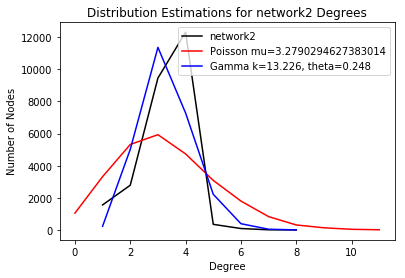

In [22]:
# Poisson or Gamma distribution
network2_poisson_mu = network2_degree_mean
network2_gamma_k = network2_degree_mean**2 / network2_degree_variance
network2_gamma_theta = network2_degree_variance / network2_degree_mean

print("network2 poisson naive estimation:", network2_poisson_mu)
print("network2 gamma naive mu estimation:", network2_gamma_k)
print("network2 gamma naive theta estimation:", network2_gamma_theta)

# generate samples from estimated degree distributions
poisson = np.random.poisson(network2_poisson_mu, network2.number_of_nodes()).round()
gamma = np.random.gamma(network2_gamma_k, network2_gamma_theta, network2.number_of_nodes()).round()

# Get the distributions (histogram of generated samples)
poisson_distro = np.unique(poisson, return_counts=True)
gamma_distro = np.unique(gamma, return_counts=True)

# Graph everything
plt.plot(network2_degree_uniques, network2_degree_counts, color='black')
plt.plot(poisson_distro[0], poisson_distro[1], color='red')
plt.plot(gamma_distro[0], gamma_distro[1], color='blue')
plt.title('Distribution Estimations for network2 Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.legend(['network2', 'Poisson mu={}'.format(network2_poisson_mu), 'Gamma k={:.3f}, theta={:.3f}'.format(network2_gamma_k, network2_gamma_theta)])

plt.show()

Looking at the graph above, network2's degrees seem to closely resemble the gamma distribution with parameters $k=13.226$ and $\theta=0.248$.

In [23]:
# Compute number of components
network2_num_components = nx.number_connected_components(network2)

# Compute components and their sizes
network2_components = sorted(nx.connected_components(network2), key=lambda C: len(C), reverse=True)
network2_component_sizes = [len(C) for C in network2_components]

# Print number of components
print("Number of connected components in network1 = %d" % network2_num_components)

# Print all sizes
print("Sizes in decreasing order: " + ", ".join(str(l) for l in network2_component_sizes[:10]))

Number of connected components in network1 = 5
Sizes in decreasing order: 26481, 30, 24, 5, 2


**WARNING:** The code block below takes a really long time to run the first time!

In [24]:
network2_apsp_counts_persist_file = 'network2_apsp_counts.txt'

network2_apsp_length_counts = {}

# Check for persisted APSP counts.
# If it exists, skip computation
if Path(network2_apsp_counts_persist_file).is_file():
    network2_apsp_length_counts = read_int_dict(network2_apsp_counts_persist_file)
    print('network2 path lengths read from file!')
    
else:
    # Get the APSP lengths
    network2_apsp_lengths = nx.all_pairs_shortest_path_length(network2)

    # Count them
    network2_apsp_length_counts = count_apsp_lengths(network2, network2_apsp_lengths)
    
    # Persist the results
    write_int_dict(network2_apsp_length_counts, network2_apsp_counts_persist_file)

network2 path lengths read from file!


In [25]:
# Compute some stats 
network2_apsp_unique_lengths = np.array(list(network2_apsp_length_counts.keys()))
network2_apsp_length_numberof = np.array(list(network2_apsp_length_counts.values()))
network2_apsp_total = sum(network2_apsp_length_numberof)
network2_apsp_length_mean = np.dot(network2_apsp_unique_lengths, network2_apsp_length_numberof)/network2_apsp_total

network2_apsp_length_mean_squared = network2_apsp_length_mean**2
network2_apsp_length_squared_mean = np.dot((network2_apsp_unique_lengths**2), network2_apsp_length_numberof)/network2_apsp_total

network2_apsp_length_variance = network2_apsp_length_squared_mean - network2_apsp_length_mean_squared
network2_apsp_length_sigma = np.sqrt(network2_apsp_length_variance)

# Print them
print('== Graph network2 path-length stats ==')
print("mean path-length = %f" % network2_apsp_length_mean)
print("standard deviation of path-lengths of network2 = %f" % network2_apsp_length_sigma)
print('---')
print("min path-length: %d" % np.min(network2_apsp_unique_lengths))
print("max path-length: %d" % np.max(network2_apsp_unique_lengths))

== Graph network2 path-length stats ==
mean path-length = 97.553202
standard deviation of path-lengths of network2 = 46.042482
---
min path-length: 0
max path-length: 258


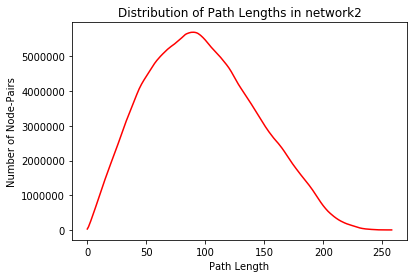

In [26]:
# Graph the distribution
plt.plot(network2_apsp_length_counts.keys(), network2_apsp_length_counts.values(), color='red')
plt.title('Distribution of Path Lengths in network2')
plt.xlabel('Path Length')
plt.ylabel('Number of Node-Pairs')
plt.show()

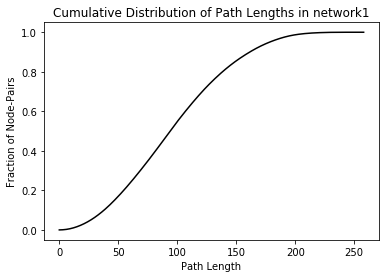

Percentage of nodes reached at path length 6: 0.27%


In [27]:
# Graph the distribution on a cumulative
cumulative = np.array(list(network2_apsp_length_counts.values()))
for i in range(1, len(cumulative)):
    cumulative[i] += cumulative[i-1]
total = cumulative[-1]

plt.plot(network2_apsp_length_counts.keys(), cumulative/total, color='black')
plt.title('Cumulative Distribution of Path Lengths in network1')
plt.xlabel('Path Length')
plt.ylabel('Fraction of Node-Pairs')
plt.show()

print('Percentage of nodes reached at path length 6: %.2f%%' % (cumulative[6]/total*100))

##### Question 2

First, taking a look at the stats for network2, we can see immediately that something is different about it.

The mean degree $3.28$ is only a little higher than that of network1 $2.85$, but the standard deviation is relatively tiny, at only 0.90 compared to network1's 20.86. This means that, in network2, nearly all of the nodes have degrees within 3 (three standard deviations is $3\times 0.90 \approx 3$) of the mean: there is far less variation in the data. This is further supported by looking at the range of degrees in the data for network2: a minimum of 1 and a maximum of 8. Note the sharp contrast with network1's distribution's seemingly non-existant upper bound.

This distribution is also far less skewed to the left compared to that of network1. This is supported by the visual representation and the difference, $median - min$. For network1, all of the nodes are piled towards the left end, resembling a monotonically decreasing real function, whereas for network2, the nodes are concentrated near the middle of the distribution. For network1, we have $median = min$, whereas for network2, $median \approx \frac{1}{2}(min + max)$.

network1's degree distribution could be closed approximated by a pareto random variable, whereas network2's can be closely approximated by a gamma distribution.

Secondly, we may consider the giant component. Both network1 and network2 have giant components, but unlike network1's 191 tiny components, network2 only has 5 components in total!

Finally, we may look at the shortest paths and path-length distributions. The average path of network2 is significantly longer than that of network1.

#### Exercise 2.6: Network identification

Based on the differences in the network outined above in Question 2 of Exercise 2.5, network1 appears to be the network of routers comprising the Internet, and network2 appears to be the network of roads around the city of New York.

For New York roads, most intersections have 3 or 4 directions of roads leaving it, so network2's average degree of $3.28$ makes sense.

It also makes sense that the degree is hard-capped at 8, since it is unreasonable to have too many roads arriving at the same intersection, especially given knowledge of urban design in the USA. The giant component makes sense because most roads are connected to the overall road network and there should not be too many isolated networks (4 isolated networks in total makes more sense than 191). 

Finally, there is a high mean path length in network2. In gridded road networks, to get from grid positions $(x_1,y_1)$ to $(x_2, y_2)$, it generally takes $|x_2 - x_1| + |y_2 - y_1|$ road segments, so this would explain the high mean path length (which represents the average number of intersections to get to your destination). Meanwhile, the path length for network1 is very low, which is highly unrealistic for a road network.

Based on the inferences that lead to the conclusion that network2 is the road network, it can be deduced that network1 is the network of routers.
